In [100]:
import torch
import torchvision 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [101]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [102]:
dataset = torchvision.datasets.EMNIST(root="../data", download=True, split="letters")
dataset

Dataset EMNIST
    Number of datapoints: 124800
    Root location: ../data
    Split: Train

In [103]:
X = dataset.data
Y = dataset.targets

In [104]:
len(dataset) * 0.8

99840.0

In [105]:
train_size = 99840
Xtrain = X[:train_size] /255
Ytrain = Y[:train_size]
Ytrain = Y[:train_size].unsqueeze(1)

Xtest = X[train_size:] /255
Ytest = Y[train_size:]
Ytest = Y[train_size:].unsqueeze(1)

In [106]:
ninput = 784
nhidden = 256
nhidden2 = 256
batch_size =64
nclasses = len(dataset.classes)

In [107]:
W1 = torch.randn(ninput, nhidden, requires_grad=True) * torch.sqrt(torch.tensor(2.0) / (ninput + nhidden))
b1 = torch.randn(1, nhidden, requires_grad=True)
W2 = torch.randn(nhidden, nhidden2, requires_grad=True)* torch.sqrt(torch.tensor(2.0) / (nhidden + nhidden2))
b2 = torch.randn(1, nhidden2, requires_grad=True)
W3 = torch.randn(nhidden2, nclasses, requires_grad=True)* torch.sqrt(torch.tensor(2.0) / (nhidden + nhidden2))
b3 = torch.zeros(1, nclasses, requires_grad=True)

gamma1 = torch.ones((100,))
gamma2 = torch.ones((50,))
beta1 = torch.zeros((100,))
beta2 = torch.zeros((50,))

dropout_rate = 0.2
D1 = torch.FloatTensor(1, nhidden).uniform_(0, 1) > dropout_rate
D2 = torch.FloatTensor(1, nhidden2).uniform_(0, 1) > dropout_rate

In [108]:
num_batches = len(Xtrain) // batch_size

In [109]:
alpha = 0.1
losses = []
val_losses = []
W1 = W1.to(device)
b1 = b1.to(device)
W2 = W2.to(device)
b2 = b2.to(device)
W3 = W3.to(device)
b3 = b3.to(device)
D1 = D1.to(device)
D2 = D2.to(device)
Xtrain = Xtrain.to(device)
Ytrain = Ytrain.to(device)
Xtest = Xtest.to(device)
Ytest = Ytest.to(device)


for epoch in range(30):
    epoch_loss = 0.0
    for i in range(num_batches):
        # Create batch
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        X_batch = Xtrain[start_idx:end_idx]
        Y_batch = Ytrain[start_idx:end_idx]

        # Forward pass
        Z1 = X_batch.view(-1, ninput) @ W1 + b1
        A1 = torch.tanh(Z1)
        D1 = torch.FloatTensor(A1.size()).uniform_(0, 1).to(A1.device) > dropout_rate
        A1_drop = A1 * D1 / (1 - dropout_rate)  # Apply dropout
        
        Z2 = A1_drop @ W2 + b2
        A2 = torch.tanh(Z2)
        D2 = torch.FloatTensor(A2.size()).uniform_(0, 1).to(A1.device) > dropout_rate
        A2_drop = A2 * D2 / (1 - dropout_rate)  # Apply dropout
        
        Z3 = A2_drop @ W3 + b3
        zmax = Z3.max(dim=1, keepdim=True).values
        znorm = Z3 - zmax
        zexp = znorm.exp()
        zexp_sum = zexp.sum(dim=1, keepdim=True)
        zexp_sum_inv = zexp_sum ** (-1)
        probs = zexp * zexp_sum_inv
        log_probs = probs.log()
        L = -log_probs[torch.arange(len(Y_batch)), Y_batch.squeeze()].mean()
        epoch_loss += L.item()

        # Backward pass
        dL_dL = torch.ones_like(L)
        dL_dlogprobs = torch.zeros_like(log_probs)
        dL_dlogprobs[torch.arange(len(Y_batch)), Y_batch.squeeze()] = -dL_dL / len(Y_batch)
        dL_dprobs = dL_dlogprobs * 1 / probs
        dL_dzexp = dL_dprobs * zexp_sum_inv
        dL_dzexp_sum_inv = (dL_dprobs * zexp).sum(1, keepdim=True)
        dL_dzexp_sum = -1 * dL_dzexp_sum_inv * zexp_sum**(-2)
        dL_dzexp += dL_dzexp_sum
        dL_dznorm = dL_dzexp * zexp.clone()
        dL_dzmax = -dL_dznorm.sum(1, keepdim=True)
        dL_dZ = dL_dznorm
        dL_dZ += torch.nn.functional.one_hot(Z3.max(dim=1).indices, nclasses) * dL_dzmax
        dL_dW3 = A2.T @ dL_dZ
        dL_db3 = dL_dZ.sum(0, keepdim=True)
        dL_dA2 = dL_dZ @ W3.T
        dL_dA2 = dL_dA2 * D2 / (1 - dropout_rate) 
        
        dL_dZ2 = dL_dA2 * (1 - A2**2)
        dL_dW2 = A1.T @ dL_dZ2
        dL_db2 = dL_dZ2.sum(0, keepdim=True)
        dL_dA1 = dL_dZ2 @ W2.T
        dL_dA1 = dL_dA1 * D2 / (1 - dropout_rate) 
        
        dL_dZ1 = dL_dA1 * (1 - A1**2)
        dL_dW1 = X_batch.view(-1, ninput).T @ dL_dZ1
        dL_db1 = dL_dZ1.sum(0, keepdim=True)

        with torch.no_grad():
            W1 -= alpha * dL_dW1
            b1 -= alpha * dL_db1
            W2 -= alpha * dL_dW2
            b2 -= alpha * dL_db2
            W3 -= alpha * dL_dW3
            b3 -= alpha * dL_db3

    # Calculate validation loss
    val_loss = 0.0
    with torch.no_grad():
        for j in range(len(Xtest) // batch_size):
            start_idx = j * batch_size
            end_idx = (j + 1) * batch_size
            X_val = Xtest[start_idx:end_idx]
            Y_val = Ytest[start_idx:end_idx]

            Z1_val = X_val.view(-1, ninput) @ W1 + b1
            A1_val = torch.tanh(Z1_val)
            Z2_val = A1_val @ W2 + b2
            A2_val = torch.tanh(Z2_val)
            Z3_val = A2_val @ W3 + b3
            val_loss += -torch.nn.functional.log_softmax(Z3_val, dim=1)[torch.arange(len(Y_val)), Y_val.squeeze()].mean().item()
    val_loss /= (len(Xtest) // batch_size)

    losses.append(epoch_loss / num_batches)
    val_losses.append(val_loss)

    print(f"Epoch {epoch}, Loss: {losses[-1]}, Validation Loss: {val_losses[-1]}")

Epoch 0, Loss: 1.159451764382613, Validation Loss: 0.6783507805604201
Epoch 1, Loss: 0.7127361494188126, Validation Loss: 0.5039055391764029
Epoch 2, Loss: 0.5991226357909349, Validation Loss: 0.43761378679520047
Epoch 3, Loss: 0.5511019733185187, Validation Loss: 0.40228308401046653
Epoch 4, Loss: 0.5194316145319205, Validation Loss: 0.3846829684690023
Epoch 5, Loss: 0.49562031070773416, Validation Loss: 0.37015114474372984
Epoch 6, Loss: 0.48582045883895497, Validation Loss: 0.3685714790263237
Epoch 7, Loss: 0.4666322235113535, Validation Loss: 0.36027366611151357
Epoch 8, Loss: 0.4591666743254814, Validation Loss: 0.3643738837244037
Epoch 9, Loss: 0.45263123519432086, Validation Loss: 0.356940032236087
Epoch 10, Loss: 0.4463337575563062, Validation Loss: 0.3562944061481036
Epoch 11, Loss: 0.4401779323386458, Validation Loss: 0.34960999634021367
Epoch 12, Loss: 0.43899900822016674, Validation Loss: 0.3595721214818649
Epoch 13, Loss: 0.4323745510660303, Validation Loss: 0.363771332131

In [110]:
# def compare_grad(s, dX, X):
#     exact = torch.all(dX == X.grad).item()
#     close = torch.allclose(dX, X.grad)
#     maxdiff = (dX - X.grad).abs().max().item()
#     print(f"{s:15s} | exact: {str(exact):5s} | approximate:{str(close):5s} | maxdiff: {maxdiff}")

In [111]:
# compare_grad('logprobs', dL_dlogprobs, log_probs)
# compare_grad('probs', dL_dprobs, probs)
# compare_grad('zexp', dL_dzexp, zexp)
# compare_grad('zexp_sum_inv', dL_dzexp_sum_inv, zexp_sum_inv)
# compare_grad('zexp_sum', dL_dzexp_sum, zexp_sum)
# compare_grad('znorm', dL_dznorm, znorm)
# compare_grad('zmax', dL_dzmax, zmax)
# # compare_grad('Z3', dL_dZ3, Z3)
# # compare_grad('W3', dL_dW3, W3)
# # compare_grad('b3', dL_db3, b3)
# compare_grad('Z2', dL_dZ2, Z2)
# compare_grad('W2', dL_dW2, W2)
# compare_grad('b2', dL_db2, b2)
# compare_grad('Z1', dL_dZ1, Z1)
# compare_grad('W1', dL_dW1, W1)
# compare_grad('b1', dL_db1, b1)

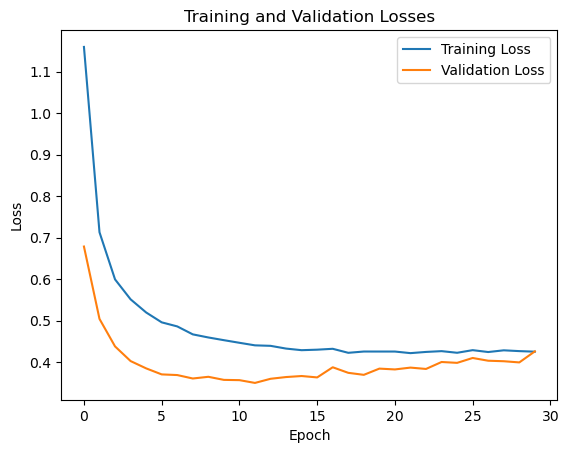

In [112]:
plt.plot(losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Nothing wrong with validation loss being lower than training loss. It simply depends on the probability distribution of the validation set. If you have a lot of dropout in your model this can easily be the case because training loss is calculated with dropout present. In calculating the validation loss dropout is disabled. Issue is is your training accuracy at an acceptable level. If it is not then reduce regularization in the model.

In [113]:
correct = 0
total = 0

with torch.no_grad():
    for i in range(len(Xtest)):
        Z1 = Xtest[i].view(1, -1) @ W1 + b1
        A1 = torch.tanh(Z1)
        Z2 = A1 @ W2 + b2
        A2 = torch.tanh(Z2)
        Z3 = A2 @ W3 + b3
        predicted_class = torch.argmax(Z3, dim=1)

        if predicted_class == Ytest[i]:
            correct += 1
        total += 1
accuracy = correct / total
print(f"Test Accuracy: {accuracy}")


Test Accuracy: 0.9060496794871795
